In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import tensorflow as tf
from tensorflow.keras.utils import Sequence
tf.debugging.set_log_device_placement(False)
k_size = 3
#from fl_mnist_implementation_tutorial_utils import *

# To splite the data between 3 clients

In [2]:
class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """

    def __init__(self, base_path, img_size=256, batch_size=1, shuffle=True):

        self.base_path = base_path
        self.img_size = img_size
        self.id = os.listdir(os.path.join(base_path, "gt_image"))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.ceil(len(self.id) / float(self.batch_size)))

    def __load__(self, id_name):
        image_path = os.path.join(self.base_path, "gt_image", (id_name ))
        label_path = os.path.join(self.base_path, "gt_binary_image", (id_name ))
        #print(image_path)
        image = cv2.imread(image_path, 1)  # Reading Image in RGB format
        image = cv2.resize(image, (self.img_size, self.img_size))
        # image = cv2.resize(image, (int(img.shape[1]/2), int(img.shape[0]/2)))
        #print(label_path)
        mask = cv2.imread(label_path, 1)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        # mask = cv2.resize(mask, (int(img.shape[1]/2), int(img.shape[0]/2)))

        # Normalizing the image
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.id):
            file_batch = self.id[index * self.batch_size:]
        else:
            file_batch = self.id[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []

        for id_name in file_batch:
            _img, _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)

        images = np.array(images)
        masks = np.array(masks)
        #masks = masks.reshape((masks.shape[0], self.img_size, self.img_size,1))
        return images, masks

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


# Part 2 - Model

In [3]:

def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x
def conv_block(x, filters, kernel_size=3, padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv
def stem(x, filters, kernel_size=3, padding='same', strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size, padding, strides)
    shortcut = Conv2D(filters, kernel_size=1, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([conv, shortcut])
    return output
def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2,2))(x)
    c = Concatenate()([u, xskip])
    return c
def ResUNet(img_h =256, img_w=256):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_h, img_w, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model




# Evaluation Metrics


In [4]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        
        return iou

    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice
    

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# scalling

In [5]:
def weight_scalling_factor(clients_trn_data):
    #get the bs
    bs = 35
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data).numpy()*bs
    return local_count/3626


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = dice_coef_loss(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [6]:



#initialize global model
global_model = ResUNet()
comms_round = 100
opt = tf.keras.optimizers.Adam(1e-3)
metrics = [f1, iou , dice_coef ]
global_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
global_model.summary()
global_mat = []
client_1 = DataGenerator2D("E:/NU/TUsimple/train_set/training/clients/client_1/", img_size=256, batch_size=8, shuffle=True)
client_2 = DataGenerator2D("E:/NU/TUsimple/train_set/training/clients/client_2/", img_size=256, batch_size=8, shuffle=True)
client_3 = DataGenerator2D("E:/NU/TUsimple/train_set/training/clients/client_3/", img_size=256, batch_size=8, shuffle=True)
test = DataGenerator2D("E:/NU/TUsimple/test_set/teest", img_size=256, batch_size=35, shuffle=True)
clients = [client_1,client_2,client_3]



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_9 (BatchNo  (None, 32, 32, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 128)  73856       ['add_2[0][0]']                  
                                                                                                  
 activation_6 (Activation)      (None, 32, 32, 128)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 128)  512        ['conv2d_11[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 batch_normalization_19 (BatchN  (None, 64, 64, 320)  1280       ['concatenate_1[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 320)  0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 128)  368768      ['activation_13[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 64, 64, 128)  512        ['conv2d_20[0][0]']              
 ormalization)                                                                                    
          

 conv2d_27 (Conv2D)             (None, 256, 256, 32  9248        ['activation_18[0][0]']          
                                )                                                                 
                                                                                                  
 add_8 (Add)                    (None, 256, 256, 32  0           ['batch_normalization_27[0][0]', 
                                )                                 'conv2d_27[0][0]']              
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 1)  33          ['add_8[0][0]']                  
                                                                                                  
Total params: 6,287,729
Trainable params: 6,280,433
Non-trainable params: 7,296
__________________________________________________________________________________________________


In [7]:
lr = 1e-3
counter = 0
pre_performance = float('inf')
best_performance = float('inf')
#commence global training loop
for comm_round in range(comms_round):
    print("---------------------------------------------------------------------------------------")
    print("Epoch ", comm_round )
    print("---------------------------------------------------------------------------------------")
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for client in clients:
        local_model = ResUNet() 
        opt = tf.keras.optimizers.Adam(lr)
        metrics = [f1, iou , dice_coef ]

        local_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(client, epochs=1 ,verbose=1,steps_per_epoch=30)
        
        #scale the model weights and add to list
        scaling_factor = 1/3
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    print("Performance Matrix ")
    #process and batch the test set 
    global_performance = global_model.evaluate(
                                    test,
                                    batch_size= 60, 
                                    verbose=1,
                                    )
    if(best_performance<=global_performance[0]):
        counter = counter + 1
    else:
        global_model.save_weights("E:/NU/TUsimple/train_set/training/clients/ResUNet/GlobalWeights.h5")
        print("Model loss imporved from", best_performance, "to",global_performance[0] )
        print("Model Saved in E:/NU/TUsimple/train_set/training/clients/ResUNet/GlobalWeights.h5" )
        best_performance = global_performance[0]
        counter = 0
    
    if(counter == 5):
        print("loss didn't imporve, so LR reduced from", lr, "to",lr*0.5 )
        lr=lr*0.5
        counter = 0
        
    global_mat.append(global_performance)
    print("---------------------------------------------------------------------------------------")


---------------------------------------------------------------------------------------
Epoch  0
---------------------------------------------------------------------------------------
30/30 [==============================] - 24s 723ms/step - loss: 0.6598 - f1: 0.3431 - iou: 0.2153 - dice_coef: 0.3402
Performance Matrix 
15/15 [==============================] - 17s 993ms/step - loss: 0.8900 - f1: 0.1097 - iou: 0.0583 - dice_coef: 0.1100
Model loss imporved from inf to 0.889974057674408
Model Saved in E:/NU/TUsimple/train_set/training/clients/ResUNet/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  1
---------------------------------------------------------------------------------------
30/30 [==============================] - 20s 541ms/step - loss: 0.4691 - f1: 0.5336 - iou: 0.3775 - dice_coef: 0.5309
Performance Matrix 
15/15 [=========

30/30 [==============================] - 11s 308ms/step - loss: 0.1568 - f1: 0.8445 - iou: 0.7542 - dice_coef: 0.8432
Performance Matrix 
15/15 [==============================] - 10s 590ms/step - loss: 0.6459 - f1: 0.3628 - iou: 0.2291 - dice_coef: 0.3558
Model loss imporved from 0.8371017575263977 to 0.645937442779541
Model Saved in E:/NU/TUsimple/train_set/training/clients/ResUNet/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  11
---------------------------------------------------------------------------------------
30/30 [==============================] - 11s 274ms/step - loss: 0.1486 - f1: 0.8514 - iou: 0.7691 - dice_coef: 0.8514
Performance Matrix 
15/15 [==============================] - 10s 592ms/step - loss: 0.6542 - f1: 0.3575 - iou: 0.2267 - dice_coef: 0.3470
-------------------------------------------------------------------

30/30 [==============================] - 10s 259ms/step - loss: 0.0696 - f1: 0.9323 - iou: 0.9048 - dice_coef: 0.9304
Performance Matrix 
15/15 [==============================] - 10s 598ms/step - loss: 0.1417 - f1: 0.8668 - iou: 0.7893 - dice_coef: 0.8594
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  30
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 257ms/step - loss: 0.0388 - f1: 0.9619 - iou: 0.9550 - dice_coef: 0.9612
Performance Matrix 
15/15 [==============================] - 10s 592ms/step - loss: 0.0501 - f1: 0.9521 - iou: 0.9336 - dice_coef: 0.9499
Model loss imporved from 0.061817217618227005 to 0.050062987953424454
Model Saved in E:/NU/TUsimple/train_set/training/clients/ResUNet/GlobalWeights.h5
--------------------------------------------------------------

30/30 [==============================] - 10s 254ms/step - loss: -0.0303 - f1: 1.0301 - iou: 1.0972 - dice_coef: 1.0303
Performance Matrix 
15/15 [==============================] - 10s 596ms/step - loss: 0.0628 - f1: 0.9421 - iou: 0.9204 - dice_coef: 0.9379
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  50
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 255ms/step - loss: -0.0221 - f1: 1.0219 - iou: 1.0782 - dice_coef: 1.0221
Performance Matrix 
15/15 [==============================] - 10s 588ms/step - loss: 0.0397 - f1: 0.9618 - iou: 0.9548 - dice_coef: 0.9594
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  51
--------------------------

30/30 [==============================] - 10s 257ms/step - loss: -0.0685 - f1: 1.0672 - iou: 1.1717 - dice_coef: 1.0685
Performance Matrix 
15/15 [==============================] - 10s 598ms/step - loss: 0.0167 - f1: 0.9850 - iou: 1.0032 - dice_coef: 0.9830
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  70
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 256ms/step - loss: -0.0689 - f1: 1.0689 - iou: 1.1793 - dice_coef: 1.0689
Performance Matrix 
15/15 [==============================] - 10s 595ms/step - loss: 0.0161 - f1: 0.9856 - iou: 1.0045 - dice_coef: 0.9834
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  71
--------------------------

30/30 [==============================] - 10s 261ms/step - loss: -0.0587 - f1: 1.0575 - iou: 1.1645 - dice_coef: 1.0587
Performance Matrix 
15/15 [==============================] - 10s 603ms/step - loss: 0.0177 - f1: 0.9841 - iou: 1.0023 - dice_coef: 0.9820
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  81
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 258ms/step - loss: -0.0607 - f1: 1.0600 - iou: 1.1652 - dice_coef: 1.0607
Performance Matrix 
15/15 [==============================] - 10s 601ms/step - loss: 0.0178 - f1: 0.9839 - iou: 1.0018 - dice_coef: 0.9818
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  82
--------------------------

15/15 [==============================] - 10s 602ms/step - loss: 0.0172 - f1: 0.9846 - iou: 1.0030 - dice_coef: 0.9824
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  91
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 255ms/step - loss: -0.0714 - f1: 1.0729 - iou: 1.1937 - dice_coef: 1.0714
Performance Matrix 
15/15 [==============================] - 10s 605ms/step - loss: 0.0171 - f1: 0.9847 - iou: 1.0034 - dice_coef: 0.9825
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  92
---------------------------------------------------------------------------------------
30/30 [==============================] - 10s 260ms/step - loss: -0.0673 - f1:

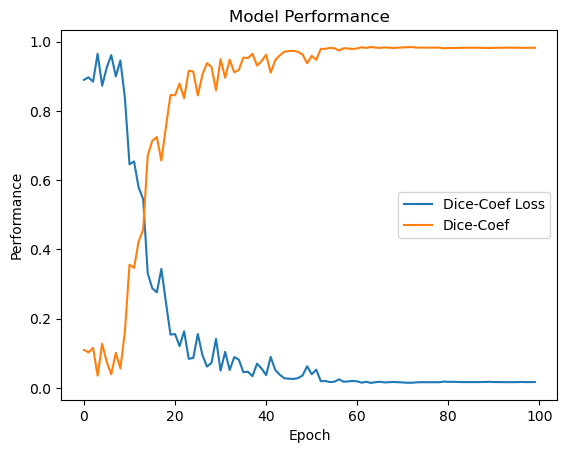

In [8]:

performance_matrix = list(map(list, zip(*global_mat)))
plt.plot(performance_matrix[0])
plt.plot(performance_matrix[3])
plt.title('Model Performance')
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Dice-Coef Loss', 'Dice-Coef'])
plt.show()

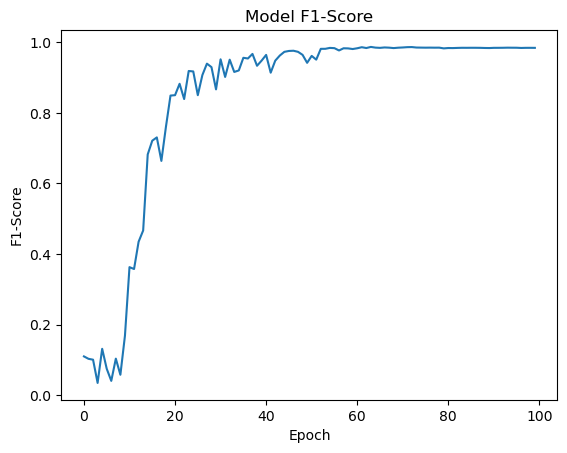

In [9]:
plt.plot(performance_matrix[1])
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.show()

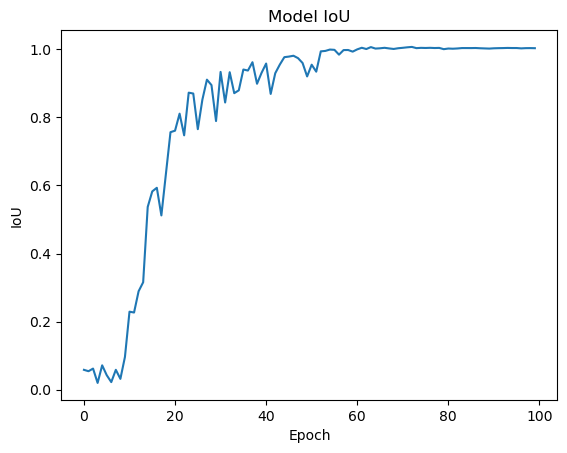

In [10]:
plt.plot(performance_matrix[2])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.show()

In [6]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\teest", img_size=256,batch_size=128, shuffle=True)
global_model = ResUNet()
global_model.load_weights('E:/NU/TUsimple/train_set/training/clients/ResUNet/GlobalWeights.h5')
global_model.compile(loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[f1, iou , dice_coef ])
evaluate = global_model.evaluate(val_generator,batch_size= 60, verbose=1,)

4/4 [==============================] - 18s 3s/step - loss: 0.0147 - f1: 0.9878 - iou: 1.0071 - dice_coef: 0.9854


In [6]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\testing", img_size=256,batch_size=128, shuffle=False)
global_model = ResUNet()
global_model.load_weights('E:/NU/TUsimple/train_set/training/clients/ResUNet/GlobalWeights.h5')


In [7]:
X, y = val_generator.__getitem__(0)


predict = global_model.predict(X)
print(predict.shape)

4/4 [==============================] - 13s 182ms/step
(128, 256, 256, 1)


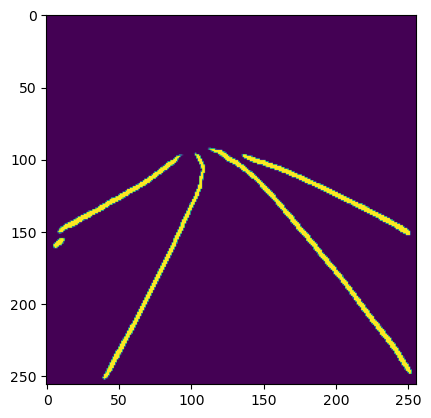

In [8]:
img = predict[5]
plt.imshow(img)

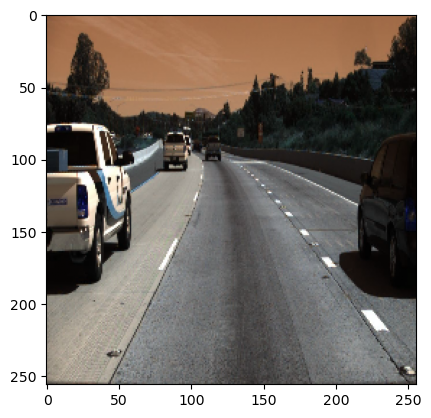

In [9]:
img = X[5]
plt.imshow(img)